# Pytorch code for binary image classification

## Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, random_split

### Check GPU availability

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Load & Process Data

In [ ]:
# Data transformation
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize with mean and std
])

# Load MNIST dataset
full_dataset = datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root="./data", train=False, transform=transform, download=True)

# Convert labels: Even -> 0, Odd -> 1
full_dataset.targets = (full_dataset.targets % 2 == 1).long()
test_dataset.targets = (test_dataset.targets % 2 == 1).long()

# Split dataset: 70% Train, 20% Test, 10% Evaluation
train_size = int(0.7 * len(full_dataset))
eval_size = int(0.1 * len(full_dataset))
test_size = len(full_dataset) - train_size - eval_size  # Remaining for test

train_dataset, test_dataset, eval_dataset = random_split(full_dataset, [train_size, test_size, eval_size])

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
eval_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

In [ ]:
print(train_size)
print(eval_size)
print(test_size)

42000
6000
12000


## Define model
Multi-layer perceptron

In [ ]:
class SimpleMLP(nn.Module):
    def __init__(self, input_size=28*28, hidden_size=128):
        super(SimpleMLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size) # fully connected (input neurons, output neurons)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, 1)  # Binary output
        self.sigmoid = nn.Sigmoid()  # Sigmoid for probability output

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize model
model = SimpleMLP().to(device)

In [ ]:
import torchsummary
torchsummary.summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]         100,480
              ReLU-2                  [-1, 128]               0
            Linear-3                    [-1, 1]             129
           Sigmoid-4                    [-1, 1]               0
Total params: 100,609
Trainable params: 100,609
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.38
Estimated Total Size (MB): 0.39
----------------------------------------------------------------


##  Define Loss & Optimizer

In [ ]:
criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
optimizer = optim.Adam(model.parameters(), lr=0.001)

## Training loop

In [ ]:
num_epochs = 10
train_losses = []
eval_losses = []

for epoch in range(num_epochs):
    # Training
    model.train()
    total_loss = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.float().to(device)
        optimizer.zero_grad()
        # FORWARD PASS
        outputs = model(images).squeeze()
        loss = criterion(outputs, labels)
        # ERROR BACK-PROPAGATION
        loss.backward()
        # UPDATE THE WEIGHTS according to the gradient
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Evaluation (Validation Set)
    model.eval()
    eval_loss = 0
    with torch.no_grad():
        for images, labels in eval_loader:
            images, labels = images.to(device), labels.float().to(device)
            # FORWARD PASS
            outputs = model(images).squeeze()
            loss = criterion(outputs, labels)
            eval_loss += loss.item()

    avg_eval_loss = eval_loss / len(eval_loader)
    eval_losses.append(avg_eval_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f} | Eval Loss: {avg_eval_loss:.4f}")


Epoch [1/10] -> Train Loss: 0.2094 | Eval Loss: 0.1336
Epoch [2/10] -> Train Loss: 0.1081 | Eval Loss: 0.0946
Epoch [3/10] -> Train Loss: 0.0847 | Eval Loss: 0.0848
Epoch [4/10] -> Train Loss: 0.0722 | Eval Loss: 0.0755
Epoch [5/10] -> Train Loss: 0.0640 | Eval Loss: 0.0678
Epoch [6/10] -> Train Loss: 0.0579 | Eval Loss: 0.0623
Epoch [7/10] -> Train Loss: 0.0536 | Eval Loss: 0.0641
Epoch [8/10] -> Train Loss: 0.0489 | Eval Loss: 0.0654
Epoch [9/10] -> Train Loss: 0.0466 | Eval Loss: 0.0585
Epoch [10/10] -> Train Loss: 0.0433 | Eval Loss: 0.0626


## Plot training and evaluation curves

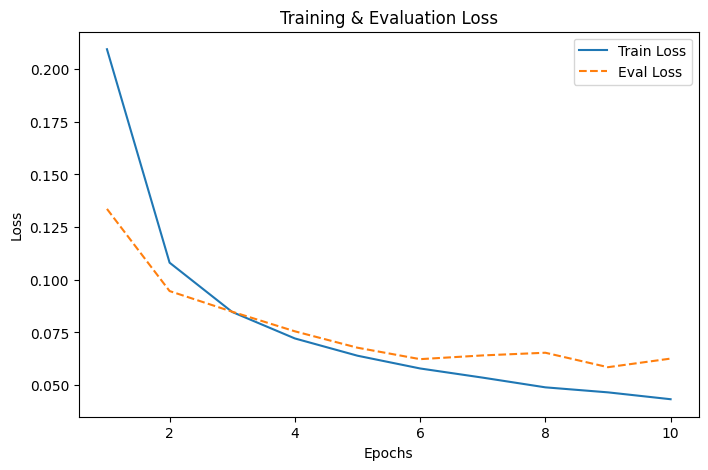

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss")
plt.plot(range(1, num_epochs+1), eval_losses, label="Eval Loss", linestyle="--")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Evaluation Loss")
plt.legend()
plt.show()

## Test and train accuracy

In [ ]:
model.eval()
correct_train = 0
total_train = 0
correct_test = 0
total_test = 0

# Train Accuracy
with torch.no_grad():
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        predicted = (outputs > 0.5).long()
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

train_acc = 100 * correct_train / total_train

# Test Accuracy
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).squeeze()
        predicted = (outputs > 0.5).long()
        correct_test += (predicted == labels).sum().item()
        total_test += labels.size(0)

test_acc = 100 * correct_test / total_test

print(f"Train Accuracy: {train_acc:.2f}%") # 99.8
print(f"Test Accuracy: {test_acc:.2f}%") # 98.2

Train Accuracy: 98.74%
Test Accuracy: 97.48%
